In [1]:
import os, yaml
import numpy as np
from scipy.interpolate import CubicSpline

In [2]:
param_dir = 'output/Run2/signal'
stats = {}
for f in os.listdir(param_dir):
    if not f.endswith('.yaml'):# or '700' in f:
        continue
    f = os.path.join(param_dir, f)
    info = f.split('fit_info_signal_')[1].split('.')[0] # 'mass_SR'
    with open(f, 'r') as file:
        stats[info] = yaml.safe_load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'output/Run2/signal'

In [20]:
def double_sided_cyrstall_ball(x, x0, sigmaL, sigmaR, alphaL, nL, alphaR, nR):
    AL = np.power(nL/np.abs(alphaL), nL) * np.exp(-alphaL**2/2)
    AR = np.power(nR/np.abs(alphaR), nR) * np.exp(-alphaR**2/2)
    BL = nL/np.abs(alphaL) - np.abs(alphaL)
    BR = nR/np.abs(alphaR) - np.abs(alphaR)
    if x - x0 < -alphaL*sigmaL:
        return AL*(BL-(x-x0)/sigmaL)**(-nL)
    elif x - x0 <= 0:
        return np.exp(-((x-x0)/sigmaL)**2/2)
    elif x - x0 <= alphaR*sigmaR:
        return np.exp(-((x-x0)/sigmaR)**2/2)
    else:
        return AR*(BR+(x-x0)/sigmaR)**(-nR)
    
def DCB(x, x0, sigmaL, sigmaR, alphaL, nL, alphaR, nR, event_sum):
    return event_sum * np.array([double_sided_cyrstall_ball(i, x0, sigmaL, sigmaR, alphaL, nL, alphaR, nR) for i in x])
    

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib.ticker import MultipleLocator


def interpolate_plot(mass, parameters, plot_name: str, y_name: str, x_name=r'$m(Z^\prime)$ [GeV]', year='Run2', x_min=800, x_max=3800):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))

    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, year=year, lumi=LUMI[year])


    x = np.arange(x_min, x_max+1, 50)
    cs = CubicSpline(mass, parameters)
    ax.plot(x, cs(x), color='darkorange', label='interpolation')
    ax.errorbar(mass, parameters, yerr=np.sqrt(parameters), label='simulated sample', linestyle='', fmt='o', markersize=5)
    

    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(ax.get_ylim()[0]*0.9, ax.get_ylim()[1]*1.2)
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(axis='both', which='major', width=1, length=10, labelsize=16, direction='in')
    ax.tick_params(axis='both', which='minor', width=1, length=5, labelsize=16, direction='in')
    ax.set_ylabel(y_name, fontsize=20, ha='right', y=0.95, rotation=0)
    ax.set_xlabel(x_name, fontsize=20, ha='right', x=1)
    ax.ticklabel_format(useOffset=False, style='plain')

    ax.legend(loc="best", ncol=1, frameon=False, fontsize=16)

    if not os.path.exists(f'../plots/{year}'):
        os.makedirs(f'../plots/{year}')
    plt.savefig(f"../plots/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

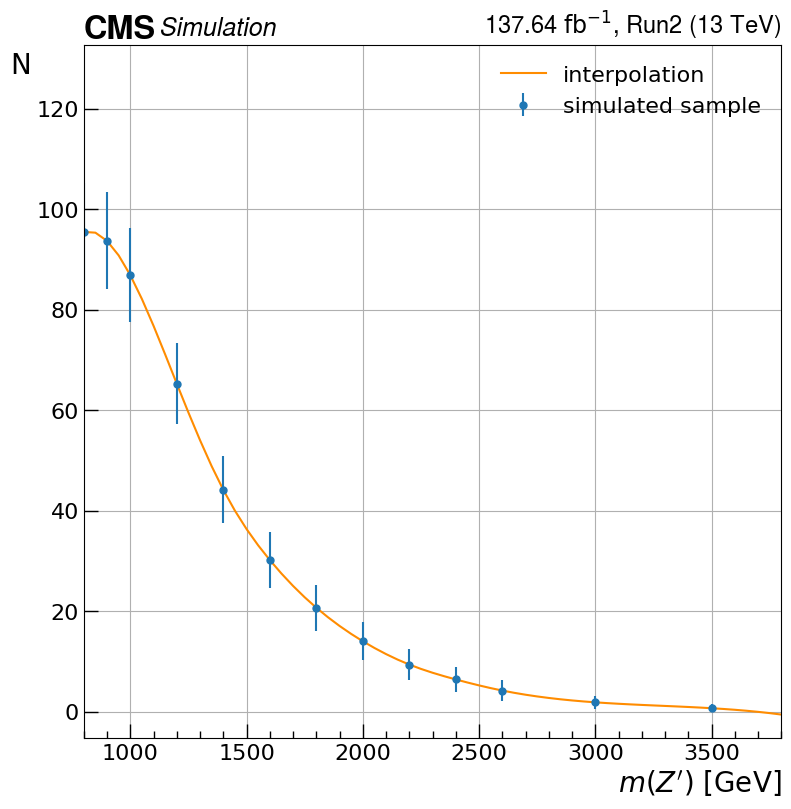

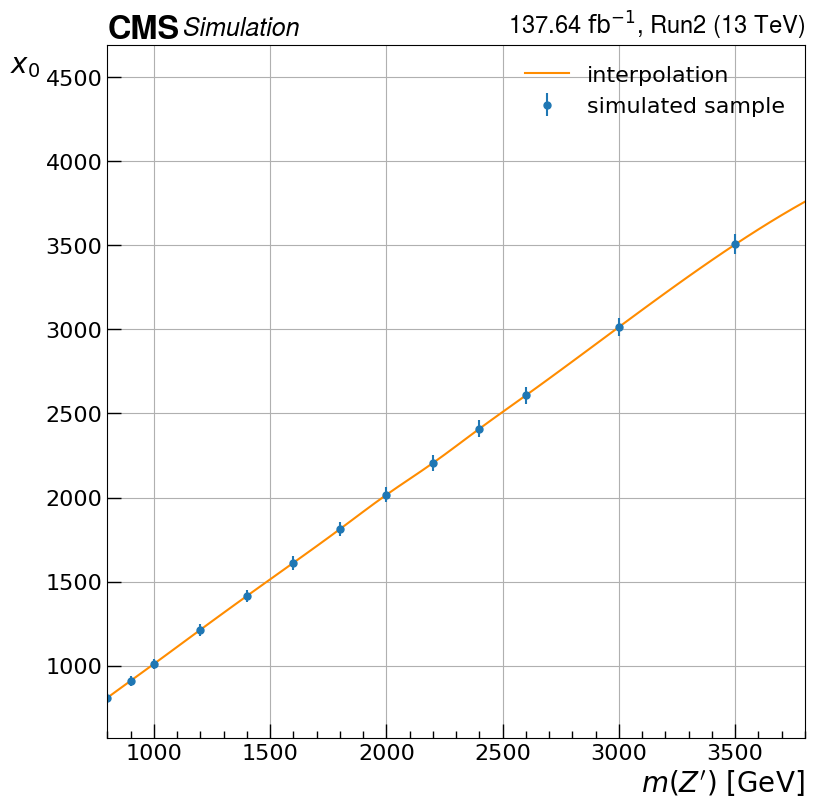

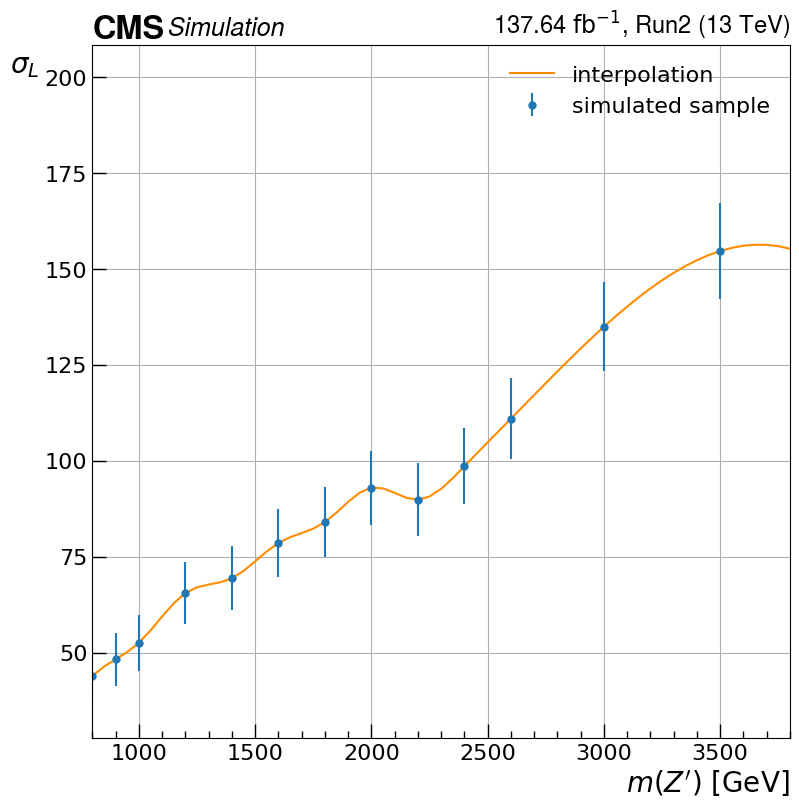

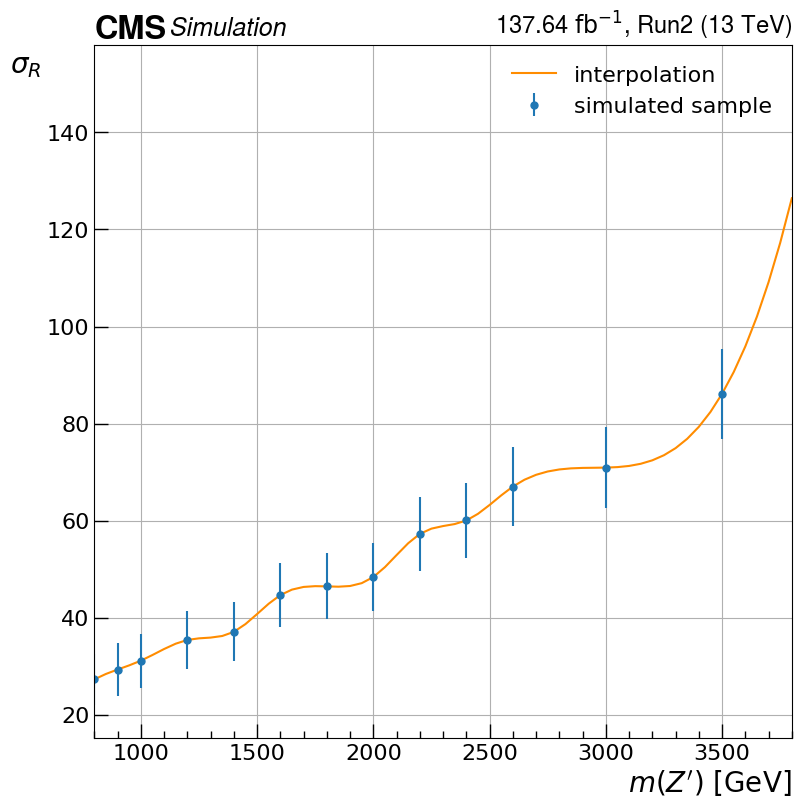

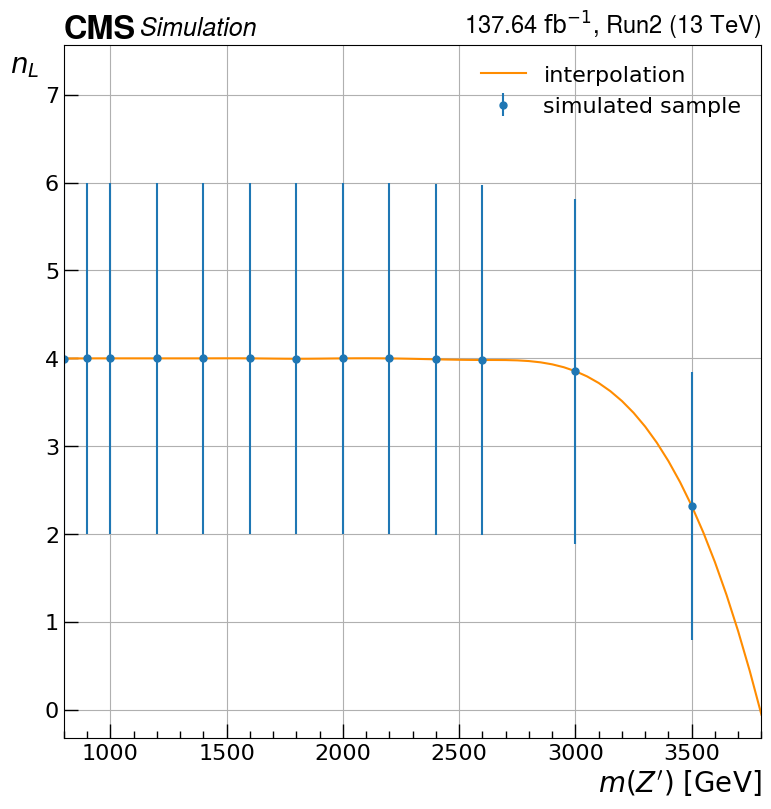

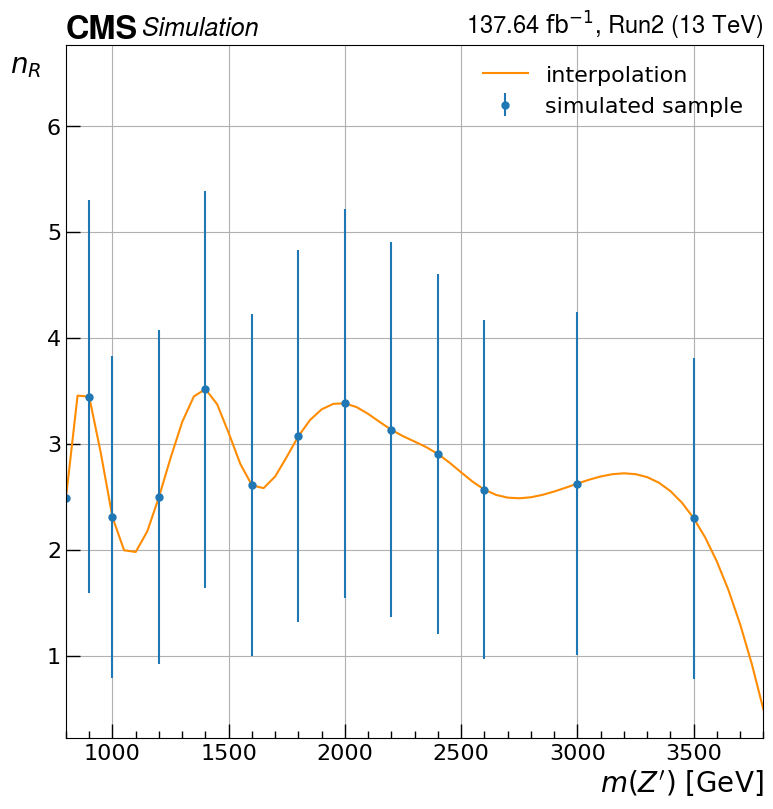

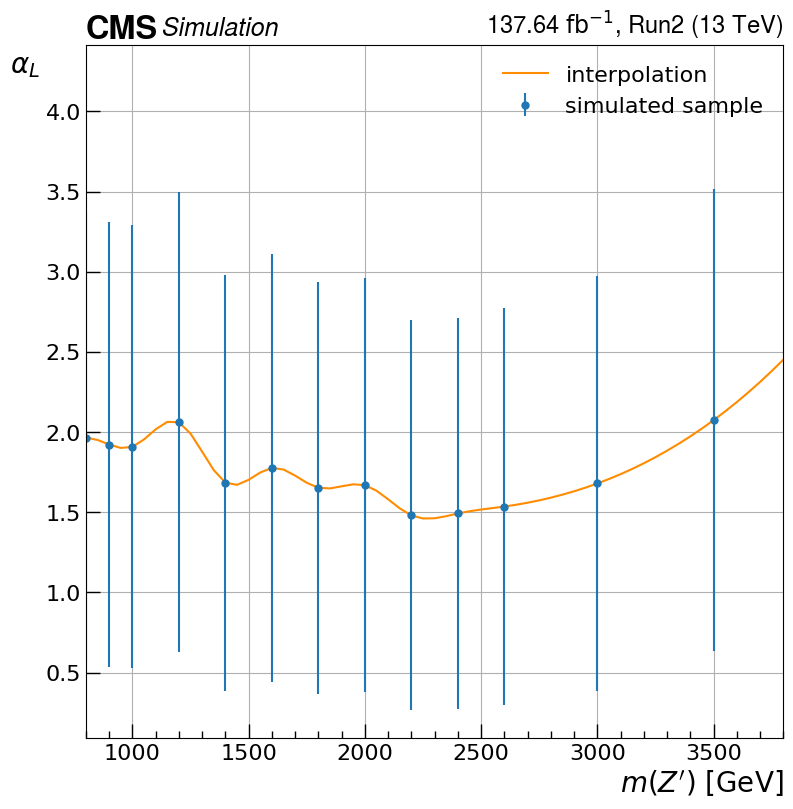

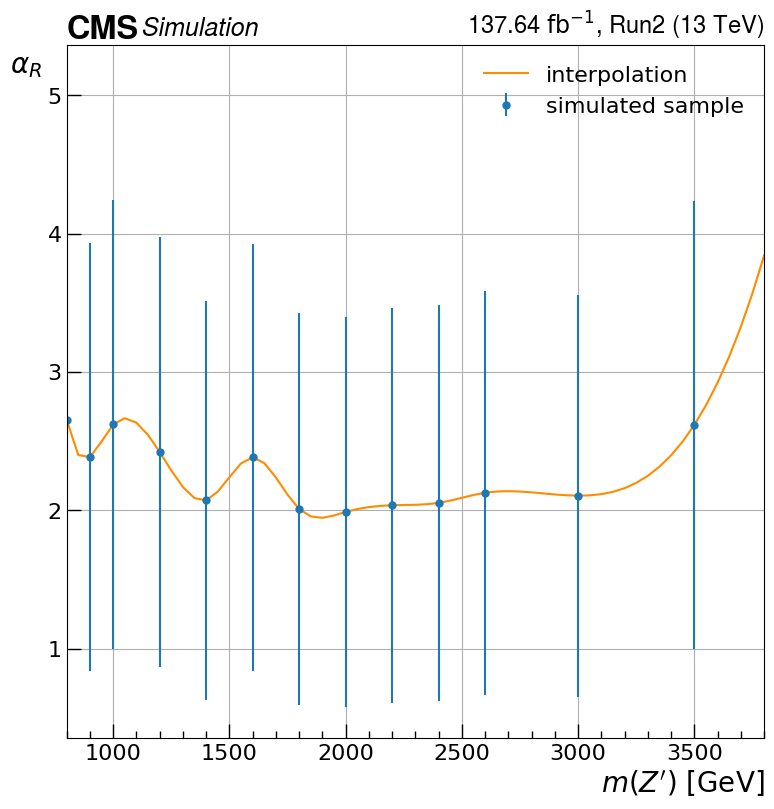

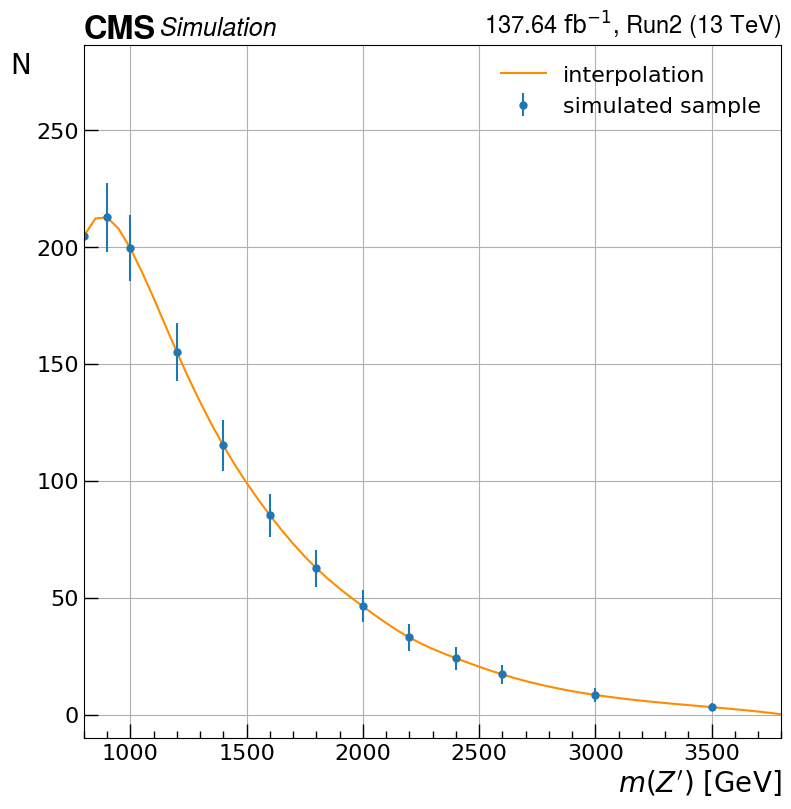

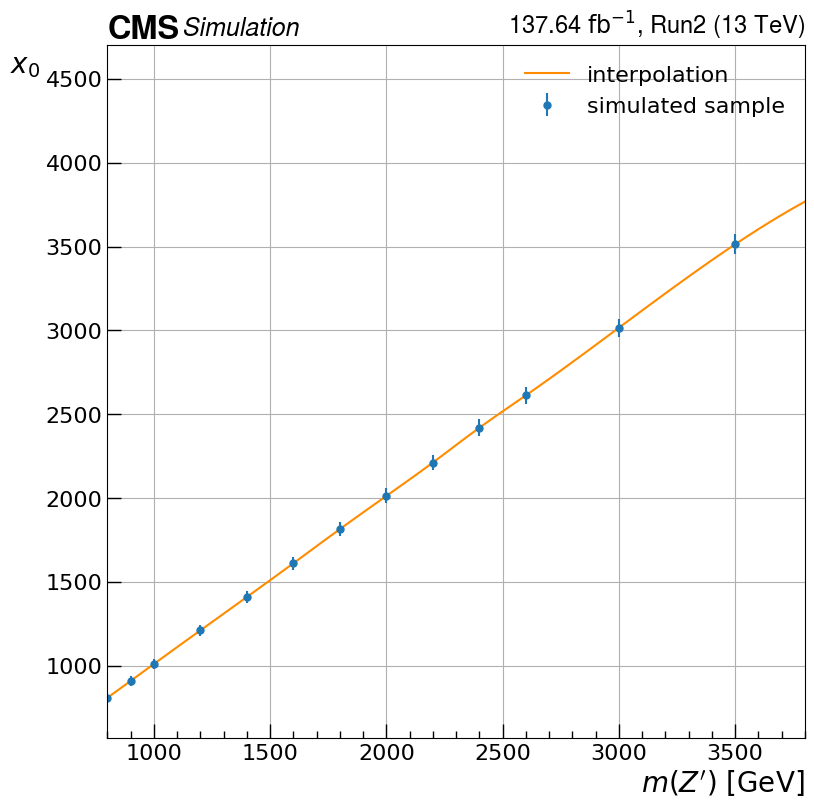

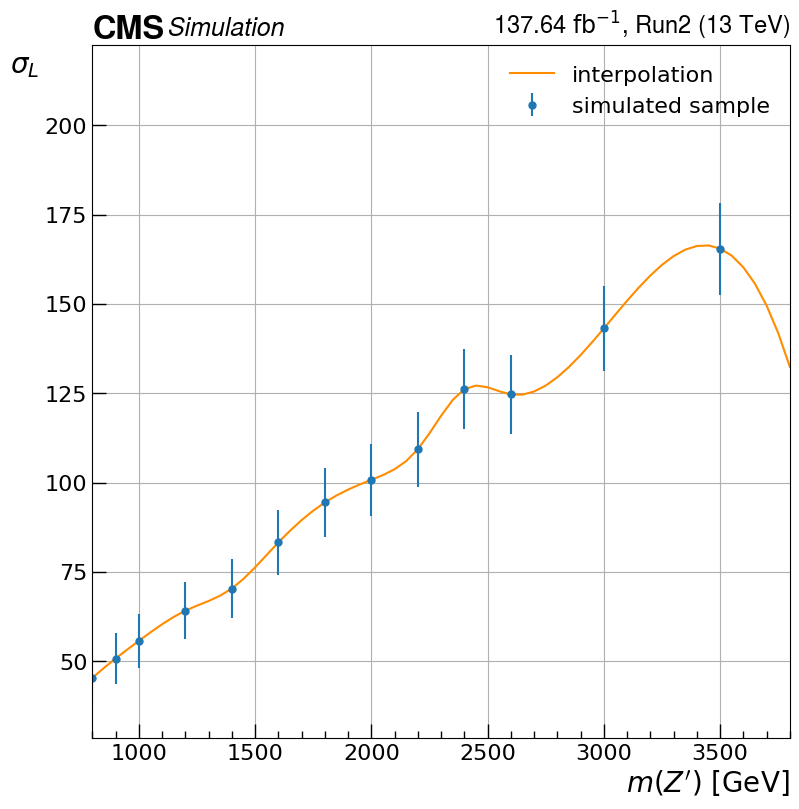

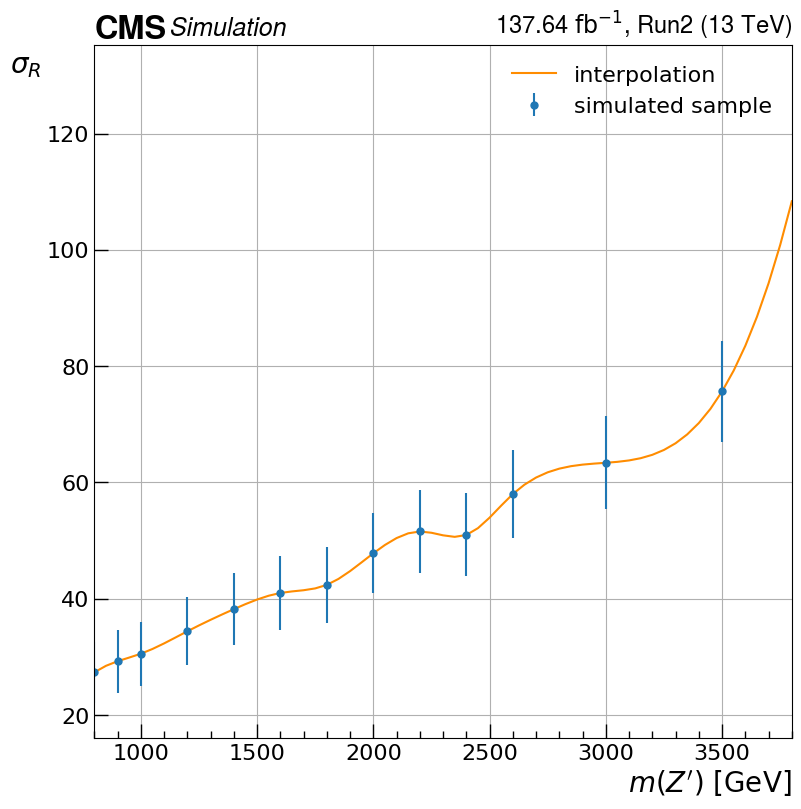

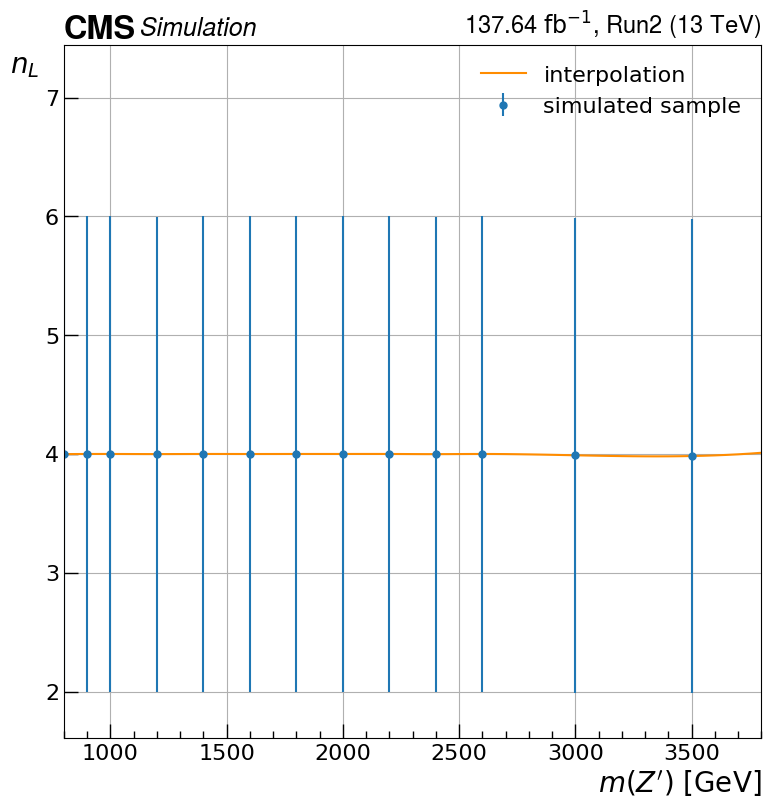

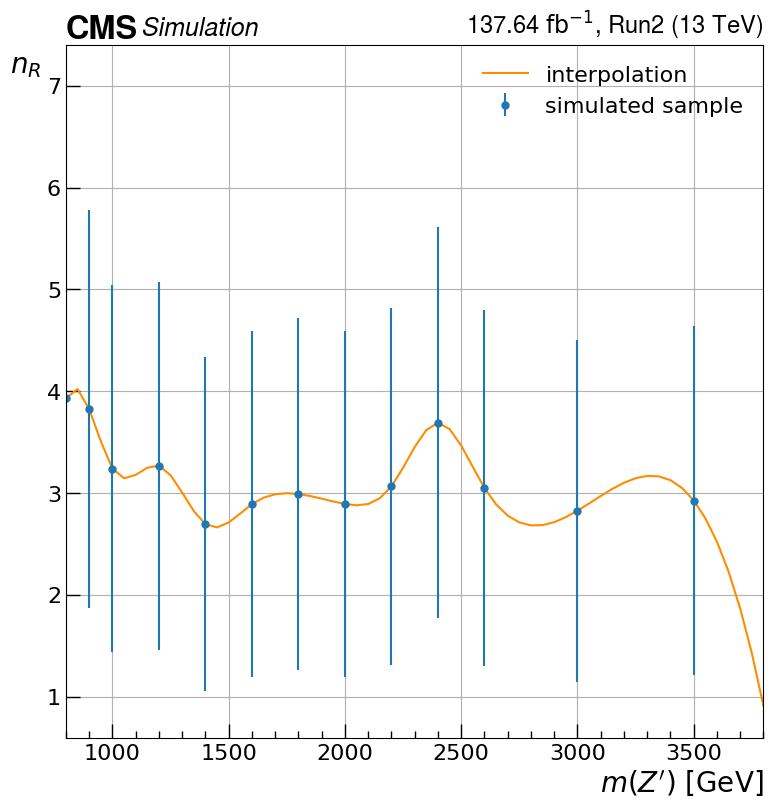

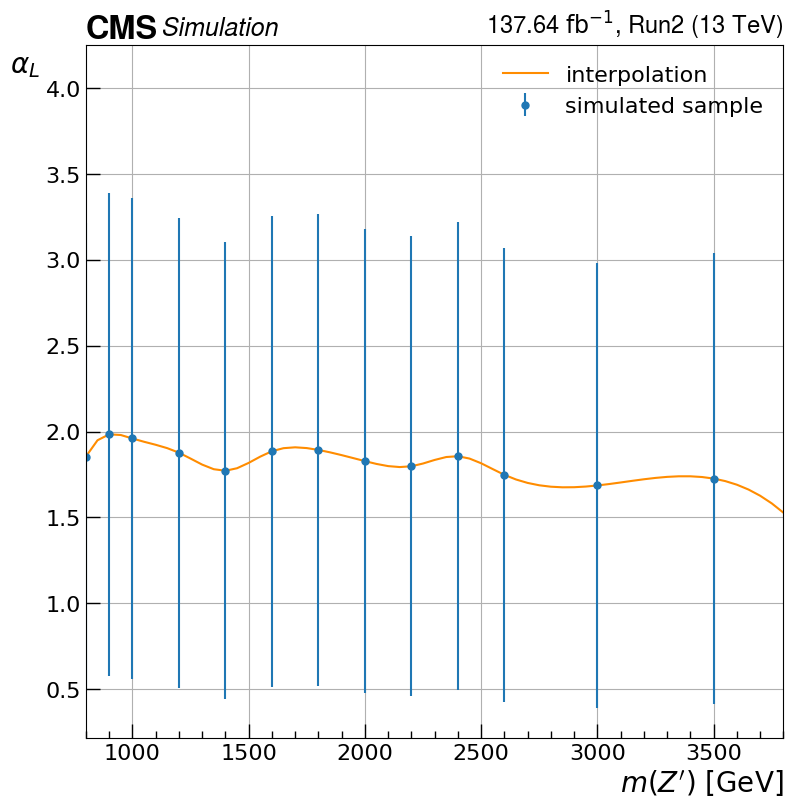

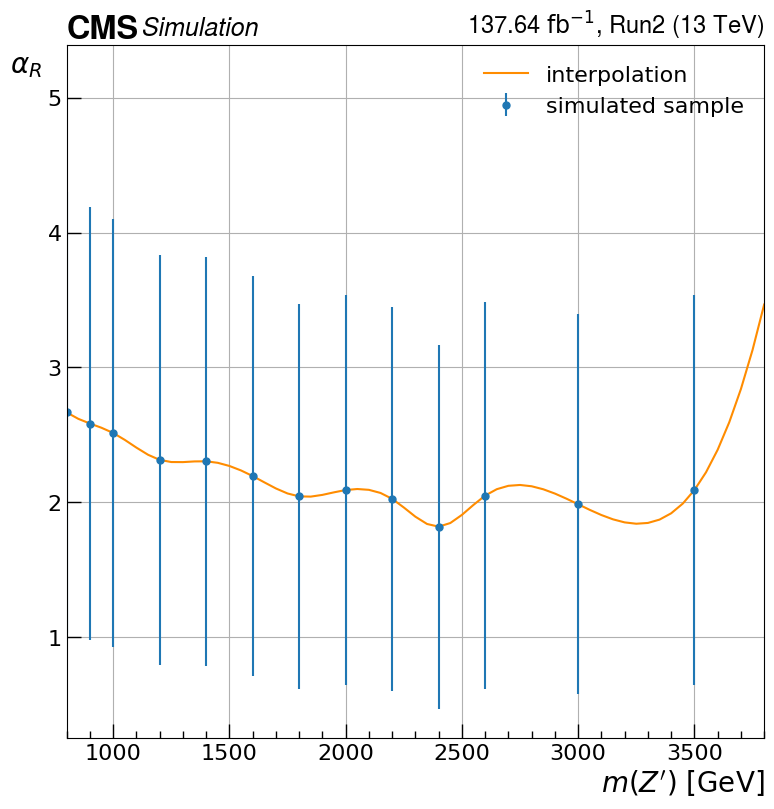

In [32]:
for SR in ['SR1', 'SR2']:
    mass = sorted([int(i.split('_')[0]) for i in stats.keys() if SR in i and '700' not in i])
    interpolate_plot(mass, parameters=[stats[f'{m}_{SR}']['event_sum'] for m in mass], plot_name=f'interpolate_{SR}_N', y_name='N')
    interpolate_plot(mass, parameters=[stats[f'{m}_{SR}']['x0'] for m in mass], plot_name=f'interpolate_{SR}_x0', y_name=r'$x_0$')
    interpolate_plot(mass, parameters=[stats[f'{m}_{SR}']['sigmaL'] for m in mass], plot_name=f'interpolate_{SR}_sigmaL', y_name=r'$\sigma_L$')
    interpolate_plot(mass, parameters=[stats[f'{m}_{SR}']['sigmaR'] for m in mass], plot_name=f'interpolate_{SR}_sigmaR', y_name=r'$\sigma_R$')
    interpolate_plot(mass, parameters=[stats[f'{m}_{SR}']['nL'] for m in mass], plot_name=f'interpolate_{SR}_nL', y_name=r'$n_L$')
    interpolate_plot(mass, parameters=[stats[f'{m}_{SR}']['nR'] for m in mass], plot_name=f'interpolate_{SR}_nR', y_name=r'$n_R$')
    interpolate_plot(mass, parameters=[stats[f'{m}_{SR}']['alphaL'] for m in mass], plot_name=f'interpolate_{SR}_alphaL', y_name=r'$\alpha_L$')
    interpolate_plot(mass, parameters=[stats[f'{m}_{SR}']['alphaR'] for m in mass], plot_name=f'interpolate_{SR}_alphaR', y_name=r'$\alpha_R$')


# Interpolate Signal

In [ ]:
def interpolate_signal(mass, stats, SR, y_name='A.U.', x_name=r'$m(Z^\prime)$ [GeV]', year='Run2', x_min=700, x_max=3800):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))

    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, year=year, lumi=LUMI[year])


    cs = {}
    for i in range(800, 3501, 50):
        for p in ['x0', 'nL', 'nR', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'event_sum']:
            cs[p] = CubicSpline(mass, [stats[f'{m}_{SR}'][p] for m in mass])

        x = np.arange(max(0.7*i, x_min), min(1.3*i, x_max), 2)
        if i in mass:
            if i==800:
                ax.plot(x, DCB(x, **{p: cs[p](i) for p in cs}), color='red', label='Simulated sample')
            else:
                ax.plot(x, DCB(x, **{p: cs[p](i) for p in cs}), color='red')
        else:
            if i==850:
                ax.plot(x, DCB(x, **{p: cs[p](i) for p in cs}), color='blue', label='Interpolated shape')
            else:
                ax.plot(x, DCB(x, **{p: cs[p](i) for p in cs}), color='blue')


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(axis='both', which='major', width=1, length=10, labelsize=16, direction='in')
    ax.tick_params(axis='both', which='minor', width=1, length=5, labelsize=16, direction='in')
    ax.set_ylabel(y_name, fontsize=20, ha='right', y=0.95, rotation=0)
    ax.set_xlabel(x_name, fontsize=20, ha='right', x=1)
    ax.ticklabel_format(useOffset=False, style='plain')

    ax.legend(loc="best", ncol=1, frameon=False, fontsize=16)

    if not os.path.exists(f'../plots/{year}'):
        os.makedirs(f'../plots/{year}')
    plt.savefig(f"../plots/{year}/interpolate_{SR}_signal.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
interpolate_signal(mass, stats, SR='SR1')
interpolate_signal(mass, stats, SR='SR2')